### Dataloader 


In this script we will perform a LSTM neural network on the CiteULike dataset. 

In [1]:
#!pip install torchtext

In [1]:
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
import torch.nn.utils.rnn as rnn_utils

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Defining our dataloader
Splitting the dataset up in a training, validation and test set. 

In [3]:
## Read datasets 
metadata=pd.read_csv('movies_metadata.csv', usecols = ['id','overview'])
metadata= metadata.drop(metadata.index[[19730,19503,29503,35587]])

#Loading small dataset for speed 
ratings = pd.read_csv('ratings_small.csv',usecols = ['userId','movieId','rating'])
ratings.columns=['userId','id','rating']

In [4]:
#converting dataset to dataframe
ratings['id']=ratings['id'].apply(int)
metadata['id']=metadata['id'].apply(int)
ratings = pd.DataFrame(ratings, columns=("userId","id","rating"))
metadata = pd.DataFrame(metadata, columns=("id","overview"))

#Merging the two datasets 
ratings = ratings.merge(metadata,on='id',how='left')
ratings=ratings.dropna(axis=0)

In [11]:
# change the movie and user id's to start at zero
def zero_indexing(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

ratings["userId"], uniq = zero_indexing(ratings["userId"].values)
ratings["id"], uniq = zero_indexing(ratings["id"].values)

ratings = ratings.sample(frac=1) # Shuffle

#Find maximum length of the longest abstract
max_length = max((len(s.split(' ')) for s in ratings.iloc[:,3]))

In [6]:
ratings.iloc[1:6,:]

,userId,id,rating,overview
28366,210,525,4.0,"In this classic German thriller, Hans Beckert,..."
74064,517,12,3.0,In a futuristic city sharply divided between t...
35870,258,407,4.0,"Kay and Jay reunite to provide our best, last ..."
19119,127,760,2.0,The four turtles travel back in time to the da...
39273,285,933,3.0,"Isabelle, a beautiful nursing student, is star..."


In [7]:
 np.unique(ratings["id"])

array([   0,    1,    2, ..., 2806, 2807, 2808])

In [12]:
# split train, validation and test in respectively 70%,20% and 10% of the data size

n=len(ratings)
trn_len=int(n*0.7)
val_len=int(n*0.2)
test_len=n-trn_len-val_len


train = ratings[:trn_len]
val = ratings[trn_len:-test_len]
test = ratings[trn_len:-val_len]

#Defining unique coloumns and userId
uniq_items = np.unique(ratings["id"])
uniq_users = np.unique(train["userId"])

# pairing the user with the movies which the user has seen
# the rating zero if a user has not seen a given movie
items = set((x[0],x[1]) for x in train[["userId","id"]].values)
pairs = []
i = 0
while(i < len(train)):
    
    item = np.random.choice(uniq_items, size = 1)[0] 
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0,0)]
        items.add((user,item))

ratings_Negatives = np.vstack((train, pairs))

train = pd.DataFrame(data = ratings_Negatives,columns = ["userId","id", "rating","overview"])

val.to_csv('movieLens/val.csv', header = False, index = False)
test.to_csv('movieLens/test.csv', header = False, index = False)

del ratings_Negatives, items, uniq_items, uniq_users, pairs, val, test

for i,val in enumerate(train["id"][n:]):
    train["id"].loc[n+i] = ratings.iloc[int(val),1]

train = train.sample(frac=1) #shuffle panda style

train.to_csv('movieLens/train.csv', header = False, index = False)


In [9]:
train

,userId,id,rating,overview
538,52,1418,4,The story of writer William Seward Burroughs a...
55845,527,782,0,0
19912,653,1420,4,Matter-transmitter sabotage leaves a British s...
46051,656,4,0,0
14742,118,474,5,A psychological thriller about an eight year o...
35445,324,1302,0,0
52247,259,444,0,0
60268,261,1099,0,0
48027,645,467,0,0
57537,355,1662,0,0


Tokenizer: ID is the User_ID, Text: is the article's abstract and Label 

In [10]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#text field is sequential data while label and ID is not. Setting Text data to lower case and setting the fixed length
#to the maximum length so all examples will be padded according to this.
#For Label and ID we set use_vocab=False because it is numerical. 
#include_lengths – Whether to return a tuple of a padded minibatch 
#and a list containing the lengths of each examples, or just a padded minibatch. Default: False.

TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length)
LABEL = Field(sequential=False, use_vocab=False)
ID = Field(sequential=False, use_vocab=False)

#Loading data
train, val, test = TabularDataset.splits(
        path='movieLens', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('ID', ID), ('Text', TEXT), ('Label', LABEL)])

#Building vocab
TEXT.build_vocab(train, vectors="glove.6B.100d")
LABEL.build_vocab(train)
ID.build_vocab(train)

.vector_cache\glove.6B.zip: 862MB [49:47, 289kB/s]                                
100%|██████████| 400000/400000 [02:27<00:00, 2718.05it/s]


In [7]:
print('Text fields:')
#print('keys of TEXT.vocab:', list(TEXT.vocab.__dict__.keys()))
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "fun" appear in the dataset:', TEXT.vocab.freqs['fun'])

print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))

Text fields:
 size of vocabulary: 5060
 vocabulary's embedding dimension: torch.Size([5060, 100])
 no. times the "fun" appear in the dataset: 1

Label fields:
 list of vocabulary (int-to-str): ['<unk>', '0', '1']
 list of vocabulary (str-to-int): {'<unk>': 0, '0': 1, '1': 2}


Choosing batchsize and defining the three iterators and setting sort_within_batch = True so the lengths in the bathsize are sorted in decreasing order. 

In [7]:
batch_size = (45, 45, 45)

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes=batch_size, sort_key=lambda x: len(x.Text), sort_within_batch = True)

### LSTM  - Building the model


In [8]:
# size of embeddings
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)
num_users = len(ID.vocab.itos)

n_hidden = 100
l1_hidden = 110

class CFNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=embedding_dim, n_hidden=n_hidden, l1_hidden=l1_hidden):
        super(CFNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        
        # use pretrained embeddings
        #self.item_emb.weight.data.copy_(TEXT.vocab.vectors)
        #self.item_emb.weight.detach_()
        
        self.lin1 = nn.Linear(embedding_dim + n_hidden, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.4)
        self.drop1 = nn.Dropout(0.5)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, batch_first = False)
        self.rnnlin = nn.Linear(n_hidden, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, u, v, hidden):
        U = self.user_emb(u)
        V = self.item_emb(v)
        
        V, hidden = self.rnn(V, hidden)
        hn, cn = hidden
        V = F.relu(self.rnnlin(hn[-1]))
        
        #batchnorm testet here
        
        x = torch.cat([U, V], dim=1)
        x = self.drop0(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        #batchnorm testet here
        
        x = self.lin2(x)
        
        x = self.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        init = torch.zeros(1, batch_size, n_hidden)
        return (init,init)

In [9]:
## Training loop
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        users,(items, seq_lengths),ratings = data
        
        batch_size = len(users)
        users = users.long()
        items = items.long()
        ratings = ratings.float()      
        ratings = ratings.view(-1)
        
        optimizer.zero_grad()
        hidden_size = model.init_hidden(batch_size)
        output = model(users, items, hidden_size)
        output = output.view(-1)

        #print(output)
        
        loss = criterion(output.float(), ratings)
        loss.backward()
        optimizer.step()
        #if batch_idx % len(train_loader.dataset)/10 == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(users), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))

def validate(model, val_loader, criterion, epoch):
    model.eval()
    outputlist = []
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            users, (items, seq_lengths), ratings = data
            batch_size = len(users)
            users = users.long()
            items = items.long()
            ratings = ratings.float()
            
            ratings = ratings.unsqueeze(1)
            hidden_size = model.init_hidden(batch_size)
            output = model(users, items, hidden_size)
            output_flat = [0 if o < 0.5 else 1 for o in output.data]
            p = output_flat.count(1)
            TP += p
            FN += len(output_flat) - p
            outputlist += [output]
            val_loss += criterion(output.float(), ratings).item() # sum up batch loss

    #print(TP, FN)
    acc = (TP + TN)/(TP + TN + FP + FN)
    #sens = TP/(TP + FN)
    val_loss /= len(val_loader)
    
    
    print(f'Epoch {epoch}: Validation average loss: {val_loss:.2f} | Accucary: {acc:.2f}')
    return acc, val_loss

def trainLoop(epochs, lr=0.001, wd = 1e-6):
    # Define model    
    model = CFNN(num_users, num_embeddings, embedding_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    
    accs = []
    losses = []
    best_acc = (-1,-1e16,1e16)
    best_loss = (-1,-1e16,1e16)
    
    for epoch in range(1, epochs + 1):
        train(model, train_iter, optimizer, criterion, epoch)
        acc, val_loss = validate(model, val_iter, criterion, epoch)
        accs += [acc]
        losses += [val_loss]
    
    
    plt.plot(range(1,epochs+1),accs)
    plt.xlabel('Epochs'), plt.ylabel('Acc')
    plt.legend(['Validation accuracy'])
    plt.show()
    plt.plot(range(1,epochs+1),losses)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend(['Validation loss'])
    plt.show()

Epoch 1: Validation average loss: 0.67 | Accucary: 0.68
Epoch 2: Validation average loss: 0.63 | Accucary: 0.65
Epoch 3: Validation average loss: 0.63 | Accucary: 0.66
Epoch 4: Validation average loss: 0.61 | Accucary: 0.65
Epoch 5: Validation average loss: 0.61 | Accucary: 0.59
Epoch 6: Validation average loss: 0.60 | Accucary: 0.58
Epoch 7: Validation average loss: 0.59 | Accucary: 0.58
Epoch 8: Validation average loss: 0.58 | Accucary: 0.63
Epoch 9: Validation average loss: 0.60 | Accucary: 0.56
Epoch 10: Validation average loss: 0.59 | Accucary: 0.61
Epoch 11: Validation average loss: 0.58 | Accucary: 0.61
Epoch 12: Validation average loss: 0.58 | Accucary: 0.61
Epoch 13: Validation average loss: 0.59 | Accucary: 0.61
Epoch 14: Validation average loss: 0.57 | Accucary: 0.61
Epoch 15: Validation average loss: 0.58 | Accucary: 0.61
Epoch 16: Validation average loss: 0.57 | Accucary: 0.61
Epoch 17: Validation average loss: 0.59 | Accucary: 0.61
Epoch 18: Validation average loss: 0.58 

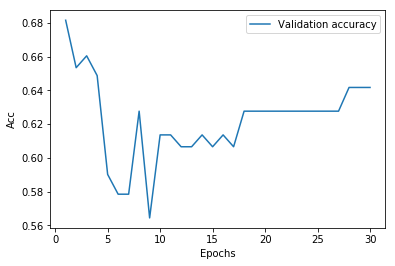

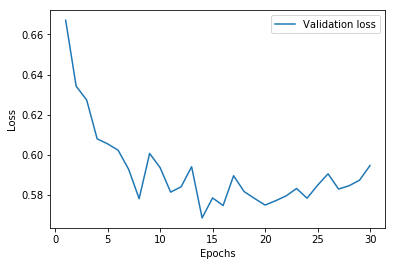

In [10]:
trainLoop(epochs=30, lr=0.0001, wd=1e-6)

In [11]:
TEXT